**1- Ouverture Pyspark et Librairies**

In [1]:
# L'exécution de cette cellule démarre l'application Spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1701638076559_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1701638076559_0001,pyspark,idle,Link,Link,None,✔


**1- Installation des packages**

In [3]:
import pandas as pd
import numpy as np
import io
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model


from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**2- Création des PATHs**

In [4]:
PATH = 's3://zh-p8-bucket'
PATH_Data = PATH+'/Test'
PATH_Result = PATH+'/Results'
print('PATH:        '+\
      PATH+'\nPATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

PATH:        s3://zh-p8-bucket
PATH_Data:   s3://zh-p8-bucket/Test
PATH_Result: s3://zh-p8-bucket/Results

**3- Chargement des données**

In [5]:
# Chargement des données avec la bonne extention et dans tous les sous dossiers :
images = spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").option("recursiveFileLookup", "true").load(PATH_Data)
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))

# impression des résultats :
print(images.select('path','label').show(5, False))

# Longueur de la DF :
images.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------------------------+----------+
|path                                           |label     |
+-----------------------------------------------+----------+
|s3://zh-p8-bucket/Test/Watermelon/r_106_100.jpg|Watermelon|
|s3://zh-p8-bucket/Test/Watermelon/r_109_100.jpg|Watermelon|
|s3://zh-p8-bucket/Test/Watermelon/r_108_100.jpg|Watermelon|
|s3://zh-p8-bucket/Test/Watermelon/r_107_100.jpg|Watermelon|
|s3://zh-p8-bucket/Test/Watermelon/r_95_100.jpg |Watermelon|
+-----------------------------------------------+----------+
only showing top 5 rows

None
22714

**4- Création des définitions (modèles ML)**

In [6]:
# Ouverture du model MobileNetV2 dans la bonne dimension :
model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))

# Suppression de la derniére couche du model (ici -2)
new_model = Model(inputs=model.input, outputs=model.layers[-2].output)

brodcast_weights = sc.broadcast(new_model.get_weights())

# Définition générale (ouverture du modèle et brodcast des weights ) :
def model_fn():
    model = MobileNetV2(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
    new_model = Model(inputs=model.input, outputs=model.layers[-2].output)
    new_model.set_weights(brodcast_weights.value)
    return new_model

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

14536120/14536120 [==============================] - 1s 0us/step

In [7]:
# Definition de redimensionnement des images en 224/224 et non 100/100 :
def preprocess(content):
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)

# Récupération des résultats des photos passées dans le model aprés être passée par le preprocess, puis flatten des résultats :
def featurize_series(model, content_series):
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)


@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    for content_series in content_series_iter:
        yield featurize_series(model, content_series)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt/yarn/usercache/livy/appcache/application_1701638076559_0001/container_1701638076559_0001_01_000001/pyspark.zip/pyspark/sql/pandas/functions.py:398: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.

**5- Extraction des features**

In [12]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
# Récupération des features via les def précédentes :
features_df = images.repartition(20).select(col("path"), col("label"), featurize_udf("content").alias("features"))

# Montre le tableau de résultats avec les features :
print(features_df.show(20))

# Longueur de la DF :
features_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+
|                path|         label|            features|
+--------------------+--------------+--------------------+
|s3://zh-p8-bucket...|    Watermelon|[0.049905494, 0.1...|
|s3://zh-p8-bucket...|    Watermelon|[0.018489283, 0.0...|
|s3://zh-p8-bucket...|Pineapple Mini|[0.0, 5.068508, 0...|
|s3://zh-p8-bucket...|Pineapple Mini|[0.015393238, 4.6...|
|s3://zh-p8-bucket...|    Watermelon|[0.11004015, 0.05...|
|s3://zh-p8-bucket...|     Raspberry|[0.010020509, 0.3...|
|s3://zh-p8-bucket...|     Raspberry|[0.6104076, 0.644...|
|s3://zh-p8-bucket...|     Raspberry|[0.079946205, 0.5...|
|s3://zh-p8-bucket...|     Pineapple|[5.0192466E-4, 3....|
|s3://zh-p8-bucket...|     Pineapple|[0.0, 4.0564113, ...|
|s3://zh-p8-bucket...|     Raspberry|[0.27468008, 0.03...|
|s3://zh-p8-bucket...|   Cauliflower|[0.0, 0.9788669, ...|
|s3://zh-p8-bucket...|    Watermelon|[0.12589383, 0.01...|
|s3://zh-p8-bucket...|Pineapple Mini|[0.0, 3.5753846, ..

In [9]:
from pyspark.ml.functions import vector_to_array
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**6- Application du PCA**

In [10]:
# Transformation des features en vecteur dense

from pyspark.ml.functions import array_to_vector

sparkDF = features_df.withColumn("features_vectorized", array_to_vector("features"))
sparkDF.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------+--------------------+--------------------+
|                path|     label|            features| features_vectorized|
+--------------------+----------+--------------------+--------------------+
|s3://zh-p8-bucket...|Watermelon|[0.049905494, 0.1...|[0.04990549385547...|
|s3://zh-p8-bucket...|Watermelon|[0.018489283, 0.0...|[0.01848928257822...|
|s3://zh-p8-bucket...|Watermelon|[0.12589383, 0.01...|[0.12589383125305...|
|s3://zh-p8-bucket...|Watermelon|[0.037083946, 0.1...|[0.03708394616842...|
|s3://zh-p8-bucket...|Watermelon|[0.11681299, 0.13...|[0.11681298911571...|
+--------------------+----------+--------------------+--------------------+
only showing top 5 rows

In [11]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol = 'features_vectorized', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(sparkDF)

# when we transform the dataframe, the old
# feature will still remain in it
df_scaled = scaler.transform(sparkDF)
#df_scaled = df_scaled.drop("path",'features','features_vectorized')
df_scaled.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+--------------------+--------------------+--------------------+
|                path|         label|            features| features_vectorized|      scaledFeatures|
+--------------------+--------------+--------------------+--------------------+--------------------+
|s3://zh-p8-bucket...|Pineapple Mini|[0.0, 5.068508, 0...|[0.0,5.0685081481...|[-0.7568072935344...|
|s3://zh-p8-bucket...|Pineapple Mini|[0.015393238, 4.6...|[0.01539323758333...|[-0.7282748230803...|
|s3://zh-p8-bucket...|    Watermelon|[0.11004015, 0.05...|[0.11004015058279...|[-0.5528399781295...|
|s3://zh-p8-bucket...|     Raspberry|[0.6104076, 0.644...|[0.61040759086608...|[0.37462697797761...|
|s3://zh-p8-bucket...|     Raspberry|[0.079946205, 0.5...|[0.07994620501995...|[-0.6086212657221...|
|s3://zh-p8-bucket...|   Cauliflower|[0.0, 0.63743114,...|[0.0,0.6374311447...|[-0.7568072935344...|
+--------------------+--------------+--------------------+--------------------+------------

In [12]:
# Compter le nombre de features
nb_composante = len(df_scaled.select('scaledFeatures').take(1)[0][0])
nb_composante

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1280

In [14]:
from pyspark.ml.functions import array_to_vector

pca, pca_matrix = reduc_dim_pca(df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# Fit sur les données standardisées
pca = PCA(
    k = nb_composante, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(df_scaled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

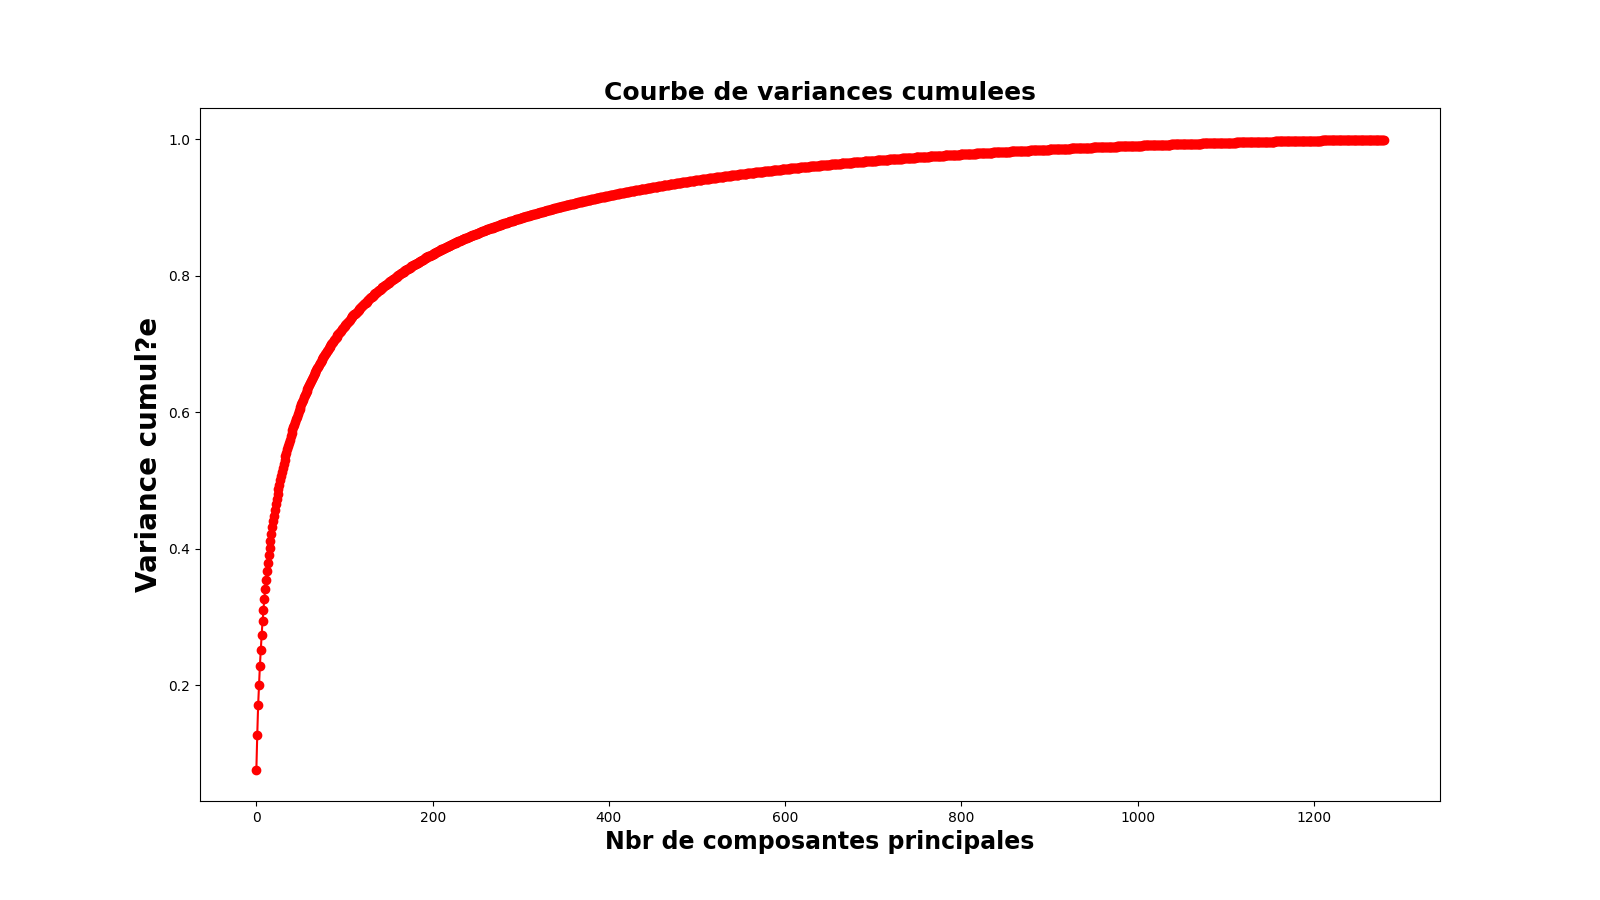

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(pca.explainedVariance.cumsum(),c="red",marker='o')
plt.title('Courbe de variances cumulees', size=18, weight='bold')
%matplot plt

In [23]:
pca.explainedVariance.cumsum()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

array([0.07666702, 0.12707709, 0.17069511, ..., 0.99997139, 0.9999858 ,
       1.        ])

In [24]:
cumsum = 0
for i in pca.explainedVariance.cumsum():
    cumsum += 1
    if(i > 0.8):
        print(
            '{} composantes expliquent 80% de la variance'.format(cumsum))
        break

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

161 composantes expliquent 80% de la variance

In [31]:
# Réduction de dimention
pca = PCA(
    k=cumsum,
    inputCol='scaledFeatures',
    outputCol='features_pca')
model_pca = pca.fit(df_scaled)
df_final = model_pca.transform(df_scaled)
df_final = df_final.drop('path', 'scaledFeatures', 'features', 'features_vectorized')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
df_final.show(6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+--------------------+
|         label|        features_pca|
+--------------+--------------------+
|Pineapple Mini|[-9.3577244748706...|
|Pineapple Mini|[-6.8753150180104...|
|Pineapple Mini|[-13.269800796270...|
|     Raspberry|[-2.4566974559442...|
|     Raspberry|[-6.0856911357879...|
|   Cauliflower|[-4.4442835489278...|
+--------------+--------------------+
only showing top 6 rows

**7- Enregistrement sous format Parquet**

In [33]:
# Enregristrement des données :
df_final.write.mode("overwrite").parquet(PATH_Result)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
import pyarrow.parquet as pq

df = pq.read_table(source=PATH_Result).to_pandas()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spark.stop()